Author: Megan Tabbutt

Latest version: 03_26_21

Notes:

Resources: 

- PyPI: https://pypi.org/project/CensusData/
- Documentation: https://jtleider.github.io/censusdata/
- County level data: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html


Datasets:

    ACS 5-year estimates (2005-2009 to 2015-2019),
    ACS 1-year estimates (2012-2019),
    ACS 3-year estimates (2010-2012 to 2011-2013),
    ACS 1-year supplemental estimates (2014-2019),
    Census 2010 Summary File 1.


## Questions:

_0. What dependencies are we already using?_

_1. What resolution do we need for the county level data?_

_2. What should we do about needing specific files? Download and include the counties mapping? Pull when needed in this method? Pull the individual states shapes? States are <50MB, counties are 1-6 MB._

_3. How much choice should they have in datasets and queries? Just do the basic now and add a new feature later for more ability? Move past the CensusData import eventually? 



## TODO:

0. Test counties functionality on multi county, multi-state made up data sets
0. Test MultiPolygon type for contins method
1. Function-ify
2. Class-ify

In [1]:
# Make Jupyter Notebook full screen 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
import censusdata
import pandas as pd
import geopandas
from shapely.geometry import Point
import matplotlib.pyplot as plt
import scipy as sp

# Step #1: connect gtfs files to pull counties from CensusData:

In [4]:
# Pull in the latitude and longitude from gtfs data 
gtfs_data_path = "data/mmt_gtfs/"
lat_lon_file = 'stops.csv'
lat_lon_df = pd.read_csv(gtfs_data_path + lat_lon_file)
lat_lon_df.head(3)

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,agency_id,jurisdiction_id,location_type,parent_station,relative_position,cardinal_direction,wheelchair_boarding,primary_street,address_range,cross_location
0,1662,1662,E Gorham & N Blount (WB),This stop (#1662) is westbound on the 698 bloc...,43.082455,-89.380990,MMT,CMAD,0,NaN,1,270.0,1,E Gorham,698,N Blount
1,2437,2437,Toepfer & Birch (NB),This stop (#2437) is northbound on the 441 blo...,43.058547,-89.441740,MMT,CMAD,0,NaN,1,0.0,1,Toepfer,441,Birch
2,7931,7931,North Star & Orion (NB),This stop (#7931) is northbound on the 741 blo...,43.087951,-89.279047,MMT,CMAD,0,NaN,3,0.0,1,North Star,741,Orion


### make into a geoDF if you want to plot below to check 
gdf = geopandas.GeoDataFrame(lat_lon_df, geometry=geopandas.points_from_xy(lat_lon_df.shape_pt_lon, lat_lon_df.shape_pt_lat))
gdf.head(3)

In [5]:
# Convert to shapely point objects in tuples
ID_points = [Point(lat_lon_df['stop_lon'][i], lat_lon_df['stop_lat'][i]) for i in range(len(lat_lon_df))]
ID_points[0].coords[:]

[(-89.38099, 43.082454999999996)]

### Trying to reduce the $n^2$ problem

Sol 1: find the NESW farthest points, if all inside the same county you are good. WRONG - logic error. 

Sol 2: What I am doing below, write description. 

In [6]:
# traverse the whole list? or will it be confined to one state? 
countyData = geopandas.read_file("/Users/megantabbutt/Downloads/cb_2018_us_county_20m/cb_2018_us_county_20m.shp")
countyData.head(3)

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,37,017,01026336,0500000US37017,37017,Bladen,06,2265887723,33010866,"POLYGON ((-78.90200 34.83527, -78.79960 34.850..."
1,37,167,01025844,0500000US37167,37167,Stanly,06,1023370459,25242751,"POLYGON ((-80.49737 35.20210, -80.29542 35.502..."
2,39,153,01074088,0500000US39153,39153,Summit,06,1069181981,18958267,"POLYGON ((-81.68699 41.13596, -81.68495 41.277..."


In [64]:
dane = countyData[countyData['NAME'] == 'Dane']
dane

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
1061,55,025,01581072,0500000US55025,55025,Dane,06,3098910897,106205317,"POLYGON ((-89.83813 43.20606, -89.73174 43.252..."


In [51]:
uniquePoints = ID_points.copy()
counties = []

startingPoint = uniquePoints[0]
startingPoint

for county in countyData.iterrows():
    if county[1]['geometry'].contains(startingPoint):
        startingCounty = county[1]['NAME']
        startingState = county[1]['STATEFP']
        print(startingCounty, " = Starting County")
        print(startingState, " = Starting State")
        
stateDF = countyData[countyData['STATEFP'] == startingState]
countyDF = stateDF[stateDF['NAME'] == startingCounty]

print(len(uniquePoints))

# Need to make this piece of code work!
remainingPoints = []
if len(counties) >= 0:
    for point in uniquePoints:
        for county in countyDF.iterrows():
            if county[1]['geometry'].contains(point):
                if county[1]['NAME'] not in counties:
                    counties.append(county[1]['NAME'])
            else:
                remainingPoints.append(point)
            break
   
# FIX THIS CODE
if remainingPoints != 0:
    print()
    
    
print(counties)

Dane  = Starting County
55  = Starting State
2135

['Dane']


### Convex Hull solution: WIP

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html

"minimal bounding box" problem

In [15]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import numpy as np

In [31]:
ID_points_array = [[lat_lon_df['stop_lon'][i], lat_lon_df['stop_lat'][i]] for i in range(len(lat_lon_df))]
ID_points_array = np.array(ID_points_array)
ID_points_array

array([[-89.38099 ,  43.082455],
       [-89.44174 ,  43.058547],
       [-89.279047,  43.087951],
       ...,
       [-89.318323,  43.12125 ],
       [-89.301303,  43.133385],
       [-89.309002,  43.124886]])

In [32]:
hull = ConvexHull(ID_points_array)
hull

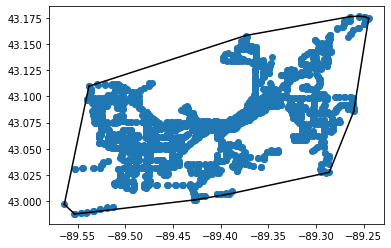

In [33]:
plt.plot(ID_points_array[:,0], ID_points_array[:,1], 'o')

for simplex in hull.simplices:
    plt.plot(ID_points_array[simplex, 0], ID_points_array[simplex, 1], 'k-')

In [48]:
hull_index = []
for simplex in hull.simplices:
    print(simplex)
    if simplex[0] not in hull_index:
        hull_index.append(simplex[0])
    if simplex[1] not in hull_index:
        hull_index.append(simplex[1])
        
hull_index.sort()
hull_index

[1451  905]
[991 905]
[991 936]
[1677 2001]
[1677  832]
[927 936]
[874 832]
[874 977]
[1956 1101]
[1302 1451]
[1302 1101]
[978 977]
[978 927]
[1953 2001]
[2019 1956]
[2019 1953]


[832,
 874,
 905,
 927,
 936,
 977,
 978,
 991,
 1101,
 1302,
 1451,
 1677,
 1953,
 1956,
 2001,
 2019]

In [49]:
hull_points = [Point(ID_points_array[i]) for i in hull_index]
hull_points

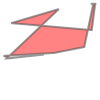

In [50]:
# need to connect in a specific order... 
from shapely import geometry

poly = geometry.Polygon([[p.x, p.y] for p in hull_points])
poly

# Step 2: Given list of counties - get stats from CensusData

In [95]:
counties = {'55':['025']}

## Step 2a: Define all the demographics you want - create dictionary of terms and codes:

Census Search API: https://data.census.gov/cedsci/table?q=Black&tid=ACSDT5Y2019.B02001&hidePreview=false


Race table = B02001

    Columns:
        https://api.census.gov/data/2019/acs/acs5/groups/B02001.html

In [ ]:
censusdata.search('acs5', 2019, 'label', 'Black')

In [119]:
# these races are "alone" as in counts for "white alone", everything else is in 'multiple'.
Demographics_acs5_2019 = {
    'Race':{'Total':'B02001_001E', 
            'White alone':'B02001_002E', 'Black or African American alone':'B02001_003E', 
            'American Indian and Alaska Native alone':'B02001_004E', 'Asian alone':'B02001_005E', 
            'Native Hawaiian and Other Pacific Islander alone':'B02001_006E'}}

In [120]:
Race = [Demographics_acs5_2019['Race'][key] for key in Demographics_acs5_2019['Race']]
print(Race)
for state in counties:
    print(state)
    for county in counties[state]:
        print(county)
        RaceInformation = censusdata.download('acs5', 2015, 
            censusdata.censusgeo([('state', state), ('county', county), ('block group', '*')]),
                                     Race)

#print(RaceInformation)
RaceInformation.rename(Demographics_acs5_2019['Race'], inplace=True)
RaceInformation

['B02001_001E', 'B02001_002E', 'B02001_003E', 'B02001_004E', 'B02001_005E', 'B02001_006E']
55
025


,B02001_001E,B02001_002E,B02001_003E,B02001_004E,B02001_005E,B02001_006E
"Block Group 1, Census Tract 118, Dane County, Wisconsin: Summary level: 150, state:55> county:025> tract:011800> block group:1",3097,3045,9,0,20,2
"Block Group 2, Census Tract 119, Dane County, Wisconsin: Summary level: 150, state:55> county:025> tract:011900> block group:2",2005,1850,83,38,18,0
"Block Group 4, Census Tract 119, Dane County, Wisconsin: Summary level: 150, state:55> county:025> tract:011900> block group:4",1488,1442,14,0,1,2
"Block Group 3, Census Tract 119, Dane County, Wisconsin: Summary level: 150, state:55> county:025> tract:011900> block group:3",891,868,4,9,3,0
"Block Group 3, Census Tract 129, Dane County, Wisconsin: Summary level: 150, state:55> county:025> tract:012900> block group:3",1174,1154,8,0,4,0
"Block Group 1, Census Tract 129, Dane County, Wisconsin: Summary level: 150, state:55> county:025> tract:012900> block group:1",1094,1075,2,0,10,0
"Block Group 2, Census Tract 2.01, Dane County, Wisconsin: Summary level: 150, state:55> county:025> tract:000201> block group:2",792,688,0,8,82,0
"Block Group 1, Census Tract 5.04, Dane County, Wisconsin: Summary level: 150, state:55> county:025> tract:000504> block group:1",1158,795,93,0,184,0
"Block Group 1, Census Tract 13, Dane County, Wisconsin: Summary level: 150, state:55> county:025> tract:001300> block group:1",1685,1380,85,26,48,0
"Block Group 2, Census Tract 15.02, Dane County, Wisconsin: Summary level: 150, state:55> county:025> tract:001502> block group:2",1531,1117,200,0,130,0


## A) Simple race statistics

## B) Cars per household

## C) ...

# Step 3: Combine states into map with geopandas and return 

In [84]:
df = geopandas.read_file('/Users/megantabbutt/Downloads/tl_2019_55_bg/tl_2019_55_bg.shp')
dane = df[df['COUNTYFP'] == '025']
dane

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
823,55,025,000401,2,550250004012,Block Group 2,G5030,S,610256,0,+43.0539636,-089.4534519,"POLYGON ((-89.45612 43.05362, -89.45611 43.055..."
1207,55,025,001300,1,550250013001,Block Group 1,G5030,S,1071749,0,+43.0544706,-089.3887963,"POLYGON ((-89.40012 43.05849, -89.39915 43.058..."
1208,55,025,001401,1,550250014011,Block Group 1,G5030,S,2579157,42576,+43.0468061,-089.3795062,"POLYGON ((-89.39403 43.04175, -89.39313 43.041..."
1209,55,025,001401,2,550250014012,Block Group 2,G5030,S,373021,0,+43.0366111,-089.4001153,"POLYGON ((-89.40664 43.03478, -89.40643 43.035..."
1210,55,025,001401,3,550250014013,Block Group 3,G5030,S,901006,7983,+43.0435985,-089.3990727,"POLYGON ((-89.40397 43.03872, -89.40396 43.038..."
1211,55,025,001401,4,550250014014,Block Group 4,G5030,S,270905,1991,+43.0468136,-089.3922873,"POLYGON ((-89.39406 43.04543, -89.39406 43.045..."
1212,55,025,001402,2,550250014022,Block Group 2,G5030,S,611334,0,+43.0303610,-089.4248669,"POLYGON ((-89.43208 43.02878, -89.43197 43.029..."
1213,55,025,001402,3,550250014023,Block Group 3,G5030,S,791499,0,+43.0306309,-089.4151312,"POLYGON ((-89.42416 43.02662, -89.41980 43.031..."
1214,55,025,001402,4,550250014024,Block Group 4,G5030,S,1407875,0,+43.0293417,-089.4374208,"POLYGON ((-89.44818 43.02571, -89.44757 43.027..."
1215,55,025,001501,2,550250015012,Block Group 2,G5030,S,685861,0,+43.0467098,-089.3570843,"POLYGON ((-89.37099 43.04723, -89.37092 43.046..."
